In [14]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import open3d as o3d
import trimesh

import ipywidgets as widgets

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
prediction_file = 'predictions/AFW_2339510439_2_9_prediction.npy'
predicted_posmap = np.load(prediction_file)
predicted_posmap = predicted_posmap.squeeze()
predicted_posmap.shape
predicted_posmap = (predicted_posmap - predicted_posmap.min()) / (predicted_posmap.max() - predicted_posmap.min())  # Normalize to [0, 1]
predicted_posmap = (predicted_posmap * 255).astype(np.uint8)

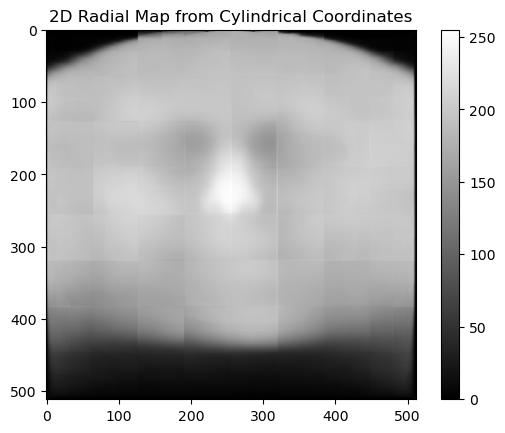

In [4]:
plt.imshow(predicted_posmap, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [5]:
true_posmap_file = 'predictions/AFW_2339510439_2_9.npz'
true_posmap = np.load(true_posmap_file)[list(np.load(true_posmap_file).keys())[0]]
true_posmap = true_posmap.squeeze()
true_posmap = (true_posmap - true_posmap.min()) / (true_posmap.max() - true_posmap.min())  # Normalize to [0, 1]
true_posmap = (true_posmap * 255).astype(np.uint8)

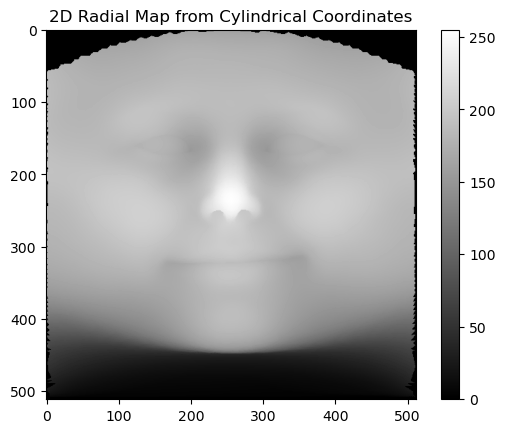

In [6]:
plt.imshow(true_posmap, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [9]:
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = 1
y_min = 0
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = predicted_posmap != 0
r_flat = predicted_posmap[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_prediction = np.vstack((x, y_flat, z)).T

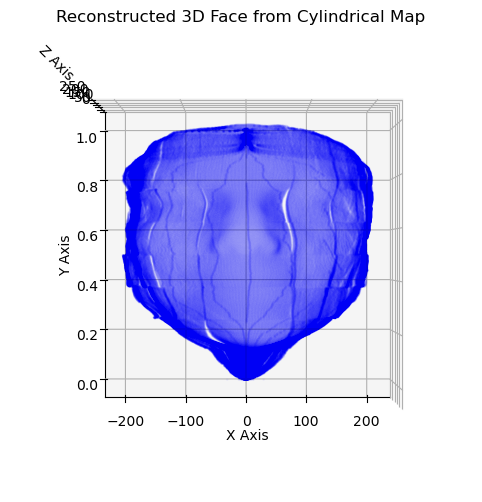

In [10]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_prediction[:,0], reconstructed_prediction[:,1], reconstructed_prediction[:,2], color='blue', s=1, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

In [11]:
# Flatten and filter out zero-radius points
valid_indices = true_posmap != 0
r_flat = true_posmap[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_gt = np.vstack((x, y_flat, z)).T

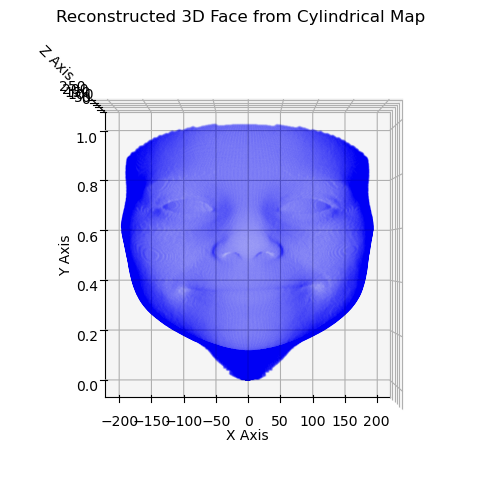

In [12]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_gt[:,0], reconstructed_gt[:,1], reconstructed_gt[:,2], color='blue', s=1, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

In [22]:
def ball_pivoting_approximation(point_cloud, alpha):
    """
    Perform an approximation of the Ball Pivoting algorithm using alpha shapes
    in Open3D to handle non-watertight surfaces.

    Args:
    point_cloud (o3d.geometry.PointCloud): The input point cloud.
    alpha (float): The alpha value to determine the level for mesh extraction.

    Returns:
    o3d.geometry.TriangleMesh: The reconstructed surface mesh.
    """

    # Estimate normals if not already present
    if not point_cloud.has_normals():
        point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    # Orient the normals (necessary step for tetra mesh creation)
    point_cloud.orient_normals_consistent_tangent_plane(k=30)

    # Compute the tetrahedral mesh of the point cloud
    tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(point_cloud)

    # The extract_triangle_mesh method needs a list of scalar values associated with the vertices.
    # Here we just use a placeholder of 1's, because we are not using scalar field to extract the surface
    values = np.ones((len(tetra_mesh.vertices),), dtype=np.float64)

    # Extract the triangle mesh (alpha shape) from the tetrahedral mesh
    triangle_mesh = tetra_mesh.extract_triangle_mesh(values=values, level=alpha)

    return triangle_mesh